### Baseline model for predicting reccomended book

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split


### Import dataset, split into train/val/test

In [12]:
df = pd.read_csv('model_data/model_data_wo_eXtern.csv')

df.head(5)

,User-ID,Age,City,Region/State,Country,Age_Missing,ISBN,Book-Rating,Rating_Categ,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2,18.0,stockton,california,usa,0,0195153448,0,Not rated,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,7,-1.0,washington,dc,usa,1,034542252,0,Not rated,NaN,NaN,NaN,NaN
2,8,-1.0,timmins,ontario,canada,1,0002005018,5,Avarege (4-5),Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,8,-1.0,timmins,ontario,canada,1,0060973129,0,Not rated,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
4,8,-1.0,timmins,ontario,canada,1,0374157065,0,Not rated,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux


Split into train/test/val

In [13]:
### Split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)  # 80% Train
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 10% Val, 10% Test

del(temp_df)

print(f"Train samples:\t\t {len(train_df)/1000} k")
print(f"Validation samples:\t {len(val_df)/1000} k")
print(f"Test samples:\t\t {len(test_df)/1000} k")

Train samples:		 689.868 k
Validation samples:	 229.956 k
Test samples:		 229.956 k


Select features and targets

In [14]:
df.columns

Index(['User-ID', 'Age', 'City', 'Region/State', 'Country', 'Age_Missing',
       'ISBN', 'Book-Rating', 'Rating_Categ', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher'],
      dtype='object')

In [33]:
#features = ['Age', 'City', 'Region/State', 'Country', 'Age_Missing','Year-Of-Publication']
features = ['Age', 'Age_Missing','Year-Of-Publication']
target_class = 'Rating_Categ'
target_reg = 'Book-Rating'

In [34]:
X_train = train_df.loc[:,features]
y_train = train_df.loc[:,target_class]

X_val = val_df.loc[:,features]
y_val = val_df.loc[:,target_class]

X_test = test_df.loc[:,features]
y_test = test_df.loc[:,target_class]

y_train_reg = train_df.loc[:,target_reg]
y_val_reg = val_df.loc[:,target_reg]
y_test_reg = test_df.loc[:,target_reg]


### Fit the model on trian set and tune on validation set

Classicication model

In [35]:
X_train.head(5)

,Age,Age_Missing,Year-Of-Publication
907805,13.0,0,1988.0
536585,26.0,0,2000.0
151525,-1.0,1,2000.0
1016105,-1.0,1,1992.0
1128635,41.0,0,2003.0


In [36]:
X_train

,Age,Age_Missing,Year-Of-Publication
907805,13.0,0,1988.0
536585,26.0,0,2000.0
151525,-1.0,1,2000.0
1016105,-1.0,1,1992.0
1128635,41.0,0,2003.0
...,...,...,...
110268,18.0,0,2002.0
259178,67.0,0,1993.0
131932,54.0,0,2002.0
671155,58.0,0,1997.0


In [37]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on your target labels (for training, validation, and test sets)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Optionally, print the class mappings to see the integer encoding
print("Class mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class mapping: {'Avarege (4-5)': np.int64(0), 'Bad (1-3)': np.int64(1), 'Excellent (8-10)': np.int64(2), 'Good (6-7)': np.int64(3), 'Not rated': np.int64(4)}


In [44]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the model (you can change parameters as needed)
model = xgb.XGBClassifier()

# Fit the model on the training set and specify the validation set for evaluation
model.fit(X_train, y_train_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [45]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate accuracy (or any other metric you prefer)
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

Validation Accuracy: 0.6269199325088278


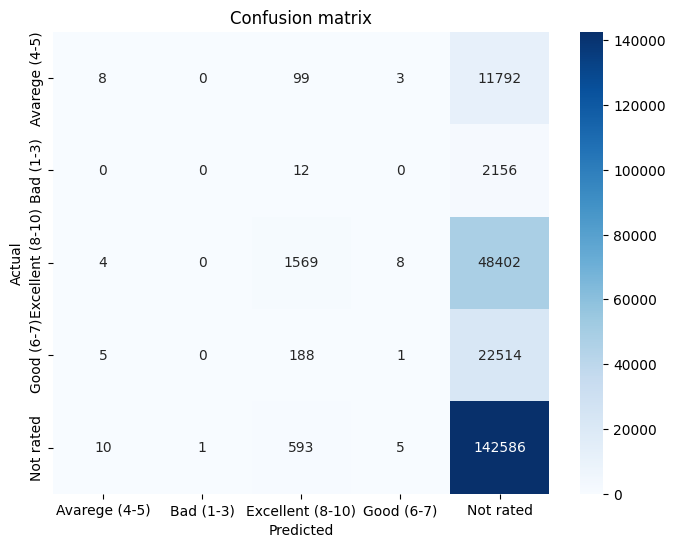

In [46]:
### Plot confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()